In [1]:
!git clone "https://github.com/jyanivaddi/ERA_V1.git"
!git pull
!pip install torchinfo
!pip install prettytable
!pip install torch_lr_finder

fatal: destination path 'ERA_V1' already exists and is not an empty directory.
fatal: not a git repository (or any of the parent directories): .git


Add all the imports

In [2]:
from __future__ import print_function
import sys
sys.path.append("ERA_V1/session_10")
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
import albumentations as A
import albumentations.augmentations as AA
from albumentations.pytorch import ToTensorV2
from utils import preview_images, plot_statistics, show_incorrect_predictions, get_incorrect_predictions, print_train_log
from custom_resnet.custom_resnet import CustomResnet, model_summary
from custom_resnet.data_loader import load_cifar10_data
from custom_resnet.training import training_loop
from custom_resnet.inference import model_test
from custom_resnet.optimizer import Optimization, find_best_lr


/usr/local/lib/python3.10/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Allocate GPU

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
resnet_model = CustomResnet(base_channels=3,num_classes=10).to(device)
model_summary(resnet_model, input_size=(3,32,32))



Layer (type:depth-idx)                   Kernel Shape              Input Shape               Output Shape              Param #                   Mult-Adds
CustomResnet                             --                        [1, 3, 32, 32]            [1, 10]                   --                        --
├─Sequential: 1-1                        --                        [1, 3, 32, 32]            [1, 64, 32, 32]           --                        --
│    └─Conv2d: 2-1                       [3, 3]                    [1, 3, 32, 32]            [1, 64, 32, 32]           1,728                     1,769,472
│    └─BatchNorm2d: 2-2                  --                        [1, 64, 32, 32]           [1, 64, 32, 32]           128                       128
│    └─ReLU: 2-3                         --                        [1, 64, 32, 32]           [1, 64, 32, 32]           --                        --
├─Layer: 1-2                             --                        --                        --  

/content/ERA_V1/session_10/custom_resnet/custom_resnet.py:157: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Define Transforms

In [4]:
train_transforms = A.Compose(
    [
        #A.augmentations.crops.transforms.RandomCrop(4,4),
        A.HorizontalFlip(p=0.5),
        AA.dropout.coarse_dropout.CoarseDropout(max_holes = 1, max_height=8,
                                                max_width=8, min_holes = 1,
                                                min_height=8, min_width=8,
                                                fill_value=(0.491, 0.482, 0.447),
                                                mask_fill_value = None),

        A.Normalize(mean=(0.491,0.482,0.447),std=(0.247,0.244,0.262)),
        ToTensorV2(),
    ]
)
test_transforms = A.Compose([
    A.Normalize(mean=(0.491,0.482,0.447),std=(0.247,0.244,0.262)),
    ToTensorV2(),
])

Define train and test loaders

In [5]:
torch.manual_seed(1)
batch_size = 512
kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}
train_loader, test_loader, class_names = load_cifar10_data(train_transforms, test_transforms, batch_size, **kwargs)

Files already downloaded and verified
Files already downloaded and verified


Show sample Images from the dataset

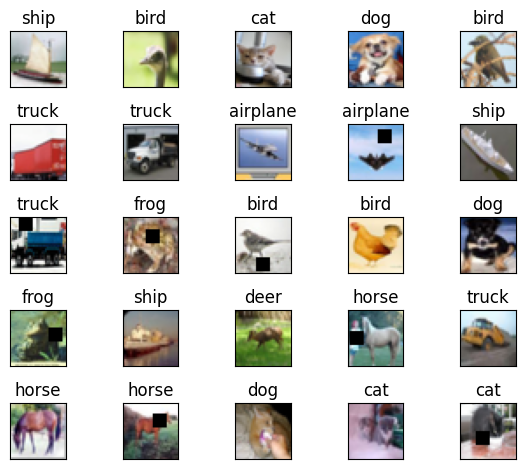

In [6]:
preview_images(train_loader,class_names, num_rows = 5, num_cols = 5)

Train model using Batch Normalization

  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.93E-02


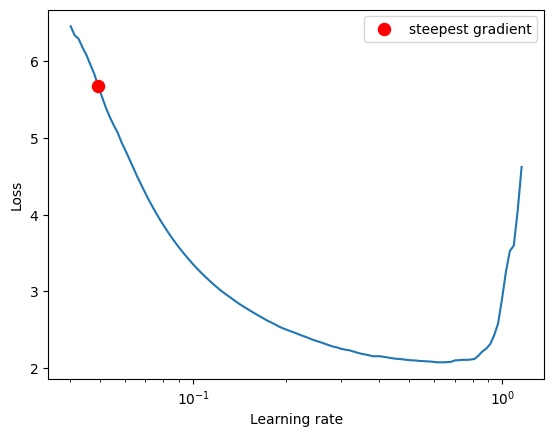

In [7]:
drop_out = 0.05
num_epochs=24
resnet_model = CustomResnet(base_channels=3, num_classes=10, drop_out_probability = drop_out).to(device)
criterion = nn.CrossEntropyLoss()
optim_obj = Optimization(resnet_model, device, train_loader, criterion, num_epochs)
lr_history = find_best_lr(resnet_model, train_loader, optim_obj.optimizer, criterion, device)


In [8]:
optim_obj.define_scheduler(max_lr=4.93E-2)
train_losses = []
test_losses = []
train_acc = []
test_acc = []
lr_values = []

for epoch in range(1,num_epochs+1):
    print(f"epoch: {epoch}")
    this_train_loss = training_loop(resnet_model, device, train_loader, optim_obj.optimizer, criterion, train_acc, train_losses)
    this_loss = model_test(resnet_model, device, test_loader, criterion, test_acc, test_losses)
    optim_obj.scheduler.step()
    lr_values.append(optim_obj.optimizer.param_groups[0]['lr'])
target_test_acc = 93.


epoch: 1


loss=1.0674073696136475 batch_id=97 Accuracy = 48.65: 100%|██████████| 98/98 [00:27<00:00,  3.57it/s]



Test set: Average loss: 0.0022, Accuracy: 6069/10000 (60.69%)

epoch: 2


loss=0.8695460557937622 batch_id=97 Accuracy = 67.10: 100%|██████████| 98/98 [00:25<00:00,  3.80it/s]



Test set: Average loss: 0.0016, Accuracy: 7160/10000 (71.60%)

epoch: 3


loss=0.7192715406417847 batch_id=97 Accuracy = 75.53: 100%|██████████| 98/98 [00:26<00:00,  3.65it/s]



Test set: Average loss: 0.0014, Accuracy: 7526/10000 (75.26%)

epoch: 4


loss=0.4696826934814453 batch_id=97 Accuracy = 80.70: 100%|██████████| 98/98 [00:26<00:00,  3.73it/s]



Test set: Average loss: 0.0012, Accuracy: 7941/10000 (79.41%)

epoch: 5


loss=0.4980491101741791 batch_id=97 Accuracy = 84.05: 100%|██████████| 98/98 [00:25<00:00,  3.79it/s]



Test set: Average loss: 0.0011, Accuracy: 8183/10000 (81.83%)

epoch: 6


loss=0.37105756998062134 batch_id=97 Accuracy = 87.04: 100%|██████████| 98/98 [00:26<00:00,  3.73it/s]



Test set: Average loss: 0.0011, Accuracy: 8108/10000 (81.08%)

epoch: 7


loss=0.34703224897384644 batch_id=97 Accuracy = 89.20: 100%|██████████| 98/98 [00:26<00:00,  3.77it/s]



Test set: Average loss: 0.0010, Accuracy: 8243/10000 (82.43%)

epoch: 8


loss=0.3168313503265381 batch_id=97 Accuracy = 90.79: 100%|██████████| 98/98 [00:25<00:00,  3.77it/s]



Test set: Average loss: 0.0009, Accuracy: 8453/10000 (84.53%)

epoch: 9


loss=0.23117178678512573 batch_id=97 Accuracy = 92.28: 100%|██████████| 98/98 [00:26<00:00,  3.76it/s]



Test set: Average loss: 0.0009, Accuracy: 8564/10000 (85.64%)

epoch: 10


loss=0.2296566516160965 batch_id=97 Accuracy = 93.22: 100%|██████████| 98/98 [00:26<00:00,  3.75it/s]



Test set: Average loss: 0.0009, Accuracy: 8580/10000 (85.80%)

epoch: 11


loss=0.17298834025859833 batch_id=97 Accuracy = 94.30: 100%|██████████| 98/98 [00:26<00:00,  3.72it/s]



Test set: Average loss: 0.0009, Accuracy: 8556/10000 (85.56%)

epoch: 12


loss=0.20722661912441254 batch_id=97 Accuracy = 95.08: 100%|██████████| 98/98 [00:25<00:00,  3.77it/s]



Test set: Average loss: 0.0009, Accuracy: 8632/10000 (86.32%)

epoch: 13


loss=0.08765784651041031 batch_id=97 Accuracy = 96.01: 100%|██████████| 98/98 [00:26<00:00,  3.75it/s]



Test set: Average loss: 0.0010, Accuracy: 8441/10000 (84.41%)

epoch: 14


loss=0.0967126339673996 batch_id=97 Accuracy = 96.27: 100%|██████████| 98/98 [00:26<00:00,  3.75it/s]



Test set: Average loss: 0.0009, Accuracy: 8647/10000 (86.47%)

epoch: 15


loss=0.137832373380661 batch_id=97 Accuracy = 96.53: 100%|██████████| 98/98 [00:26<00:00,  3.70it/s]



Test set: Average loss: 0.0009, Accuracy: 8624/10000 (86.24%)

epoch: 16


loss=0.14393021166324615 batch_id=97 Accuracy = 97.12: 100%|██████████| 98/98 [00:26<00:00,  3.76it/s]



Test set: Average loss: 0.0009, Accuracy: 8671/10000 (86.71%)

epoch: 17


loss=0.07050473988056183 batch_id=97 Accuracy = 97.19: 100%|██████████| 98/98 [00:26<00:00,  3.77it/s]



Test set: Average loss: 0.0008, Accuracy: 8719/10000 (87.19%)

epoch: 18


loss=0.07564786821603775 batch_id=97 Accuracy = 97.60: 100%|██████████| 98/98 [00:26<00:00,  3.75it/s]



Test set: Average loss: 0.0009, Accuracy: 8648/10000 (86.48%)

epoch: 19


loss=0.06862467527389526 batch_id=97 Accuracy = 97.70: 100%|██████████| 98/98 [00:26<00:00,  3.71it/s]



Test set: Average loss: 0.0009, Accuracy: 8745/10000 (87.45%)

epoch: 20


loss=0.07508541643619537 batch_id=97 Accuracy = 97.81: 100%|██████████| 98/98 [00:26<00:00,  3.73it/s]



Test set: Average loss: 0.0009, Accuracy: 8703/10000 (87.03%)

epoch: 21


loss=0.051148295402526855 batch_id=97 Accuracy = 98.15: 100%|██████████| 98/98 [00:26<00:00,  3.77it/s]



Test set: Average loss: 0.0010, Accuracy: 8663/10000 (86.63%)

epoch: 22


loss=0.07495716959238052 batch_id=97 Accuracy = 98.16: 100%|██████████| 98/98 [00:26<00:00,  3.76it/s]



Test set: Average loss: 0.0009, Accuracy: 8776/10000 (87.76%)

epoch: 23


loss=0.0550924651324749 batch_id=97 Accuracy = 97.98: 100%|██████████| 98/98 [00:25<00:00,  3.79it/s]



Test set: Average loss: 0.0010, Accuracy: 8657/10000 (86.57%)

epoch: 24


loss=0.0730089545249939 batch_id=97 Accuracy = 98.17: 100%|██████████| 98/98 [00:26<00:00,  3.76it/s]



Test set: Average loss: 0.0009, Accuracy: 8752/10000 (87.52%)



Plot LR values

In [9]:
import matplotlib.pyplot as plt
def plot_lr_values(lr_list):
    num_epochs = len(lr_list)
    plt.figure()
    plt.plot(range(1,num_epochs+1),lr_list)
    plt.xlabel('Epoch #')
    plt.ylabel("Learning Rate")
    plt.yscale('log')
    plt.show()

Plot results for Batch Norm experiment

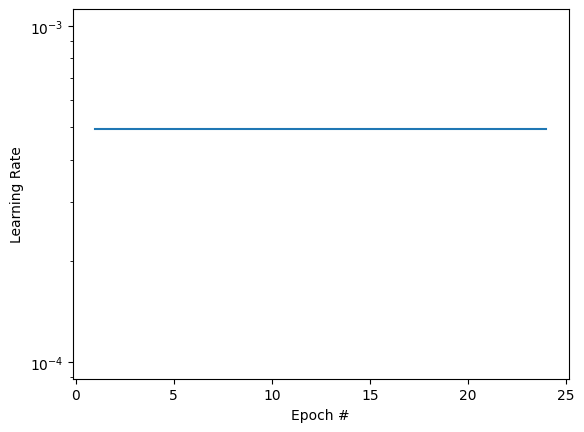

/content/ERA_V1/session_10/custom_resnet/custom_resnet.py:157: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


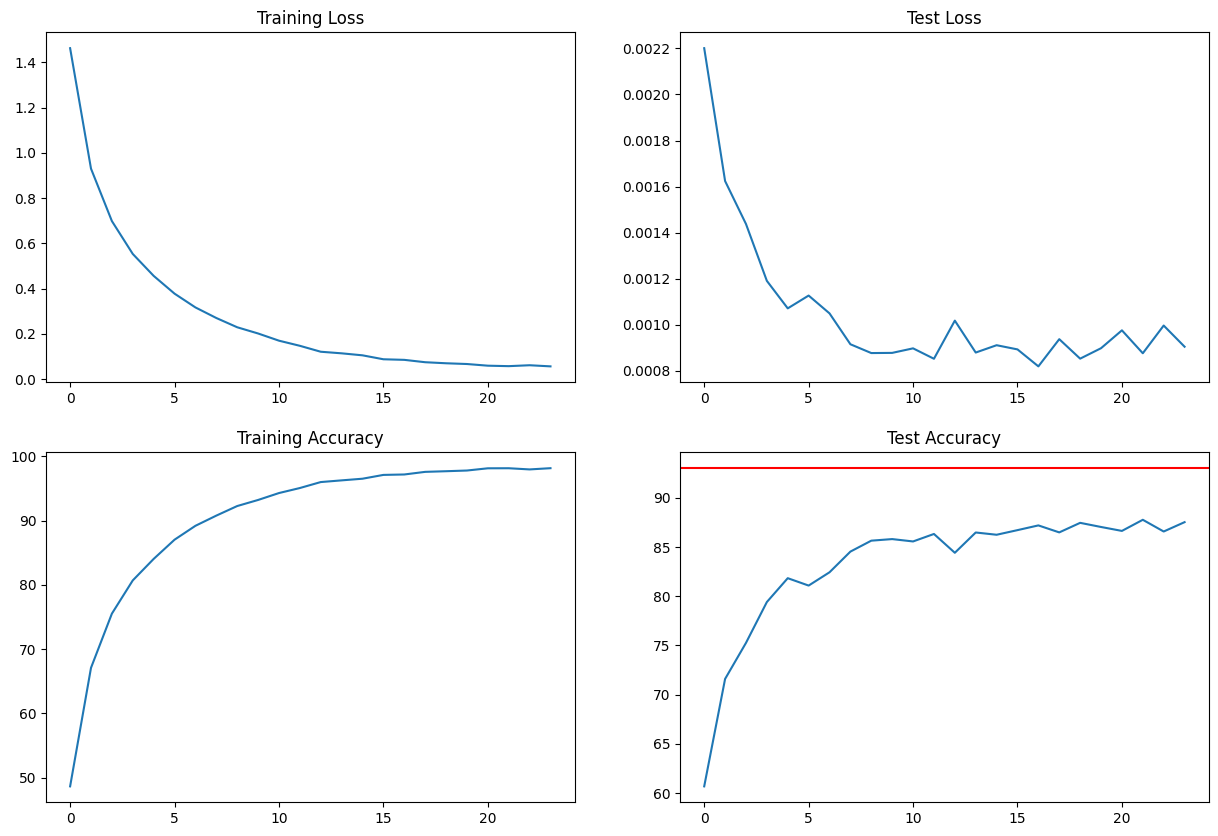

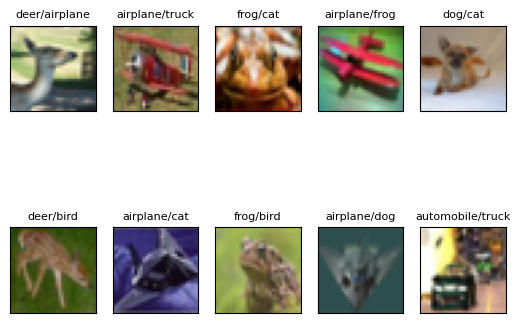

[0.000493, 0.000493, 0.000493, 0.000493, 0.000493, 0.000493, 0.000493, 0.000493, 0.000493, 0.000493, 0.000493, 0.000493, 0.000493, 0.000493, 0.000493, 0.000493, 0.000493, 0.000493, 0.000493, 0.000493, 0.000493, 0.000493, 0.000493, 0.000493]


In [11]:
plot_lr_values(lr_values)
plot_statistics(train_losses, train_acc, test_losses, test_acc, target_test_acc)
incorrect_predictions_bn = get_incorrect_predictions(resnet_model, test_loader, device)
show_incorrect_predictions(incorrect_predictions_bn, class_names, num_rows = 2, num_cols = 5)
print(lr_values)

Print Training Log

1		1.36		0.00		51.27		62.73

2		0.83		0.00		70.64		74.62

3		0.63		0.00		78.14		76.96

4		0.50		0.00		82.48		82.31

5		0.42		0.00		85.70		81.34

6		0.34		0.00		88.25		81.59

7		0.29		0.00		90.11		84.83

8		0.24		0.00		91.84		84.72

9		0.21		0.00		93.02		86.58

10		0.18		0.00		94.04		86.56

11		0.16		0.00		94.73		87.02

12		0.13		0.00		95.61		86.34

13		0.11		0.00		96.45		86.07

14		0.10		0.00		96.58		85.91

15		0.09		0.00		97.14		87.05

16		0.08		0.00		97.25		87.00

17		0.08		0.00		97.44		87.81

18		0.07		0.00		97.96		87.67

19		0.07		0.00		97.93		85.46

20		0.06		0.00		97.92		86.08

21		0.06		0.00		98.08		85.81

22		0.06		0.00		98.17		86.67

23		0.06		0.00		98.06		87.85

24		0.06		0.00		98.04		87.34

+-------+---------------------+-----------------------+----------------+--------------+
| Epoch |      Train loss     |        Val loss       | Train Accuracy | Val Accuracy |
+-------+---------------------+-----------------------+----------------+--------------+
|   1   |  1.361404087470